In [1]:
from __future__ import annotations

import pytorch_lightning as pl
from torch import nn
import torch

from matsciml.datasets.transforms import (
    PeriodicPropertiesTransform,
    PointCloudToGraphTransform,
    FrameAveraging,
)

from matsciml.lightning.data_utils import MatSciMLDataModule
from matsciml.models.base import ScalarRegressionTask

In [2]:
from matsciml.models.utils.io import * 
checkpoint_path = "/home/m3rg2000/Simulation/checkpoints-2024/mace_mat_traj_mar26_24.ckpt"
task = multitask_from_checkpoint(checkpoint_path)
task.to('cuda')

/home/m3rg2000/miniconda3/envs/matsciml/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'gate' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['gate'])`.
No ``atomic_energies`` provided, defaulting to ones.
/home/m3rg2000/miniconda3/envs/matsciml/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


/home/m3rg2000/miniconda3/envs/matsciml/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/m3rg2000/miniconda3/envs/matsciml/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/m3rg2000/miniconda3/envs/matsciml/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.


MultiTask Training module:
MaterialsProjectDataset-regression0
MaterialsProjectDataset-gff_regression0

In [3]:
norm_factors={
    "energy_mean": -214.69845189724998,
    "energy_std": 218.69620660947086,
    "corrected_total_energy_mean": -214.69845189724998,
    "corrected_total_energy_std": 218.69620660947086
}

In [4]:
# Load Data
dm = MatSciMLDataModule(
    "MaterialsProjectDataset",
    train_path="/home/m3rg2000/matsciml/Scale_new_lmdb/10k_new",#TRAIN_PATH,
    # val_split=VAL_PATH,
    # test_split=VAL_PATH,
    dset_kwargs={
        "transforms": [
            PeriodicPropertiesTransform(cutoff_radius=6.0, adaptive_cutoff=True),
            PointCloudToGraphTransform(
                "pyg",
                node_keys=["pos", "atomic_numbers"],
            ),
        ],
    },
    batch_size=1,
)

dm.setup()
train_loader = dm.train_dataloader()
dataset_iter = iter(train_loader)
batch = next(dataset_iter)


In [5]:
from torch_geometric.data import Data, Batch
# def batch2cuda(batch):
#     for key in batch.keys():
#         if type(batch[key])==torch.Tensor:
#             batch[key]=batch[key].to('cuda')
#     batch['graph']=batch['graph'].to('cuda')
def batch2cuda(batch):
    # Recursively move all tensors in nested structures to 'cuda'
    # batch['graph']=batch['graph'].to('cuda')
    if isinstance(batch, dict):
        return {k: batch2cuda(v) for k, v in batch.items()}
    elif isinstance(batch, list):
        return [batch2cuda(v) for v in batch]
    elif isinstance(batch, torch.Tensor):
        return batch.to('cuda')
    elif isinstance(batch, Data) or isinstance(batch, Batch):
        return batch.to('cuda')
    else:
        return batch
    

In [6]:
counter=0
Predictions_e=[]
Actuals_e=[]
for batch in train_loader:
    batch2cuda(batch)
    Result=task.forward(batch)

    Pred_Energy=Result['regression0']['corrected_total_energy'].item()*norm_factors['energy_std']+norm_factors['energy_mean']
    Pred_Forces=Result['gff_regression0']['force']

    Actual_Energy=batch['targets']['corrected_total_energy'].item()
    Actual_Forces=batch['targets']['force']

    Predictions_e+=[Pred_Energy]
    Actuals_e+=[Actual_Energy]
    counter+=1
    if(counter>10):
        break



RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "<eval_with_key>.21", line 49, in forward
    einsum_3 = torch.functional.einsum('edb,eca->ecdab', reshape_5, reshape_3)
    reshape_12 = reshape_3.reshape(getitem_4, 64)
    einsum_4 = torch.functional.einsum('ca,cab->cab', reshape_12, reshape_11);  reshape_12 = reshape_11 = None
               ~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
    einsum_5 = torch.functional.einsum('dbc,dca->dba', einsum_4, reshape_5);  einsum_4 = reshape_5 = None
    reshape_13 = einsum_5.reshape(getitem_4, 192);  einsum_5 = None
RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 11.75 GiB of which 15.12 MiB is free. Process 392269 has 174.00 MiB memory in use. Process 2007541 has 10.59 GiB memory in use. Process 1709378 has 150.00 MiB memory in use. Process 3487595 has 554.00 MiB memory in use. Including non-PyTorch memory, this process has 222.00 MiB memory in use. Of the allocated memory 82.87 MiB is allocated by PyTorch, and 17.13 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


In [ ]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Predicted')

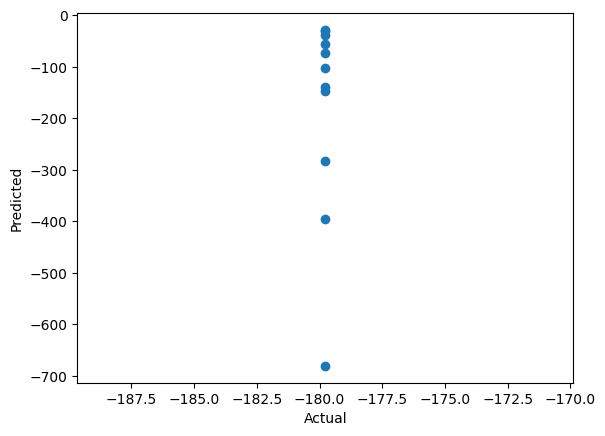

In [ ]:
plt.scatter(Actuals_e,Predictions_e)
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from tqdm import tqdm

# Initialize lists for storing predictions and actual values
def initialize_prediction_lists():
    return {
        'Predictions_corr_e': [],
        'Actuals_corr_e': [],
        'Predictions_e': [],
        'Actuals_e': [],
        'Predictions_Fx': [],
        'Actuals_Fx': [],
        'Predictions_Fy': [],
        'Actuals_Fy': [],
        'Predictions_Fz': [],
        'Actuals_Fz': []
    }

# Function to process a data loader
def process_data_loader(data_loader, norm_factors, task, limit=None):
    results = initialize_prediction_lists()
    counter = 0

    for batch in tqdm(data_loader):
        Result = task.forward(batch)

        Pred_Energy_corr = Result['regression0']['corrected_total_energy'].item() * norm_factors['energy_std'] + norm_factors['energy_mean']
        Pred_Energy = Result['force_regression0']['energy'].item() * norm_factors['energy_std'] + norm_factors['energy_mean']

        Pred_Forces = Result['force_regression0']['force']
        Actual_Energy_corr = batch['targets']['energy'].item()
        Actual_Energy = batch['targets']['corrected_total_energy'].item()
        
        Actual_Forces = batch['targets']['force']

        results['Predictions_corr_e'].append(Pred_Energy_corr)
        results['Actuals_corr_e'].append(Actual_Energy_corr)
        
        results['Predictions_e'].append(Pred_Energy)
        results['Actuals_e'].append(Actual_Energy)
        
        results['Predictions_Fx'] += Pred_Forces[:, 0].reshape(-1).detach().numpy().tolist()
        results['Actuals_Fx'] += Actual_Forces[:, 0].reshape(-1).detach().numpy().tolist()

        results['Predictions_Fy'] += Pred_Forces[:, 1].reshape(-1).detach().numpy().tolist()
        results['Actuals_Fy'] += Actual_Forces[:, 1].reshape(-1).detach().numpy().tolist()

        results['Predictions_Fz'] += Pred_Forces[:, 2].reshape(-1).detach().numpy().tolist()
        results['Actuals_Fz'] += Actual_Forces[:, 2].reshape(-1).detach().numpy().tolist()

        counter += 1
        if limit and counter >= limit:
            break

    return results

# Load data
dm = MatSciMLDataModule(
    "MaterialsProjectDataset",
    train_path="/home/civil/phd/cez218288/scratch/Scaling_lmdb_new/10k_new",
    test_split="/home/civil/phd/cez218288/scratch/Scaling_lmdb_new/test_new",
    dset_kwargs={
        "transforms": [
            PeriodicPropertiesTransform(cutoff_radius=6.0, adaptive_cutoff=True),
            PointCloudToGraphTransform(
                "pyg",
                node_keys=["pos", "atomic_numbers"],
            ),
        ],
    },
    batch_size=1,
)

dm.setup()
train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

# Process training data
train_results = process_data_loader(train_loader, norm_factors, task, limit=100)

# Process test data
test_results = process_data_loader(test_loader, norm_factors, task, limit=100)

# Function to plot R² score with train and test data
# Function to plot R² score with train and test data
def plot_r2_score(train_actual, train_pred, test_actual, test_pred, title="Title", suffix="10k_Faenet"):
    save_dir = '/home/civil/phd/cez218288/scratch/Simulation/plots/'  # Ensure this path ends with a slash

    # Calculate R² score for train and test data
    r2_train = r2_score(train_actual, train_pred)
    r2_test = r2_score(test_actual, test_pred)

    # Create the scatter plot
    plt.figure(figsize=(6, 6))  # Adjust the figure size as needed
    plt.scatter(train_actual, train_pred, label='Train', color='blue')
    plt.scatter(test_actual, test_pred, label='Test', color='green')
    plt.xlabel("Actual", fontsize=20, fontweight='bold')
    plt.ylabel("Predicted", fontsize=20, fontweight='bold')
    plt.xticks(rotation=90, fontsize=20, fontweight='bold')
    plt.yticks(fontsize=20, fontweight='bold')
    # Plot the 45-degree line
    min_val = min(min(train_actual), min(test_actual), min(train_pred), min(test_pred))
    max_val = max(max(train_actual), max(test_actual), max(train_pred), max(test_pred))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
    plt.title(title, fontsize=20, fontweight='bold')

    # Annotate the R² scores on the plot
    plt.text(0.05, 0.95, f'Train R² = {r2_train:.5f}', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', verticalalignment='top', color='blue')
    plt.text(0.05, 0.90, f'Test R² = {r2_test:.5f}', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', verticalalignment='top', color='green')

    # Save the plot to the specified location with the title in the filename
    filename = f"{title.replace(' ', '_')}_{suffix}.png"
    plt.savefig(f'{save_dir}{filename}', bbox_inches='tight')  # Use bbox_inches='tight' to adjust the bounding box

    # Show the plot
    plt.show()
    # Clear the current figure to avoid overlap
    plt.clf()


# Plot and save the results for combined training and test data
plot_r2_score(train_results['Actuals_corr_e'], train_results['Predictions_corr_e'], test_results['Actuals_corr_e'], test_results['Predictions_corr_e'], "Corrected Total Energy", "10k_mace")
plot_r2_score(train_results['Actuals_e'], train_results['Predictions_e'], test_results['Actuals_e'], test_results['Predictions_e'], "Energy", "10k_mace")
plot_r2_score(train_results['Actuals_Fx'], train_results['Predictions_Fx'], test_results['Actuals_Fx'], test_results['Predictions_Fx'], "Fx", "10k_mace")
plot_r2_score(train_results['Actuals_Fy'], train_results['Predictions_Fy'], test_results['Actuals_Fy'], test_results['Predictions_Fy'], "Fy", "10k_mace")
plot_r2_score(train_results['Actuals_Fz'], train_results['Predictions_Fz'], test_results['Actuals_Fz'], test_results['Predictions_Fz'], "Fz", "10k_mace")


  0%|          | 0/10000 [00:00<?, ?it/s]


KeyError: 'energy'